# Denoising

In this notebook we will used advanced sparsity promotying solvers and appropriate sparsyfing transforms (e.g. local plane waves) to denoise seismic data.

The mathematical problem can be states as

$$J = ||\mathbf{d} - \mathbf{S}^H * \mathbf{x}||_2 + \epsilon ||\mathbf{x}||_1$$

where $\mathbf{d}$ is the real data, $\mathbf{x}$ is the denoised data we want to estimate and  $\mathbf{S}$ is the sparsyfing transform.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import fista

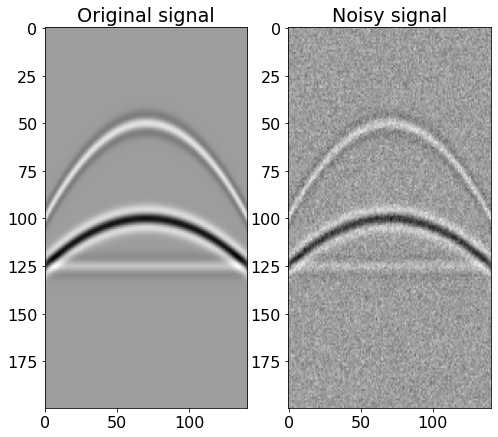

In [2]:
###### Input parameters
par = {'ox':-140, 'dx':2,    'nx':141,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-20]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate data
_, data =  parabolic2d(x,t, t0_m, px_m, pxx_m,amp_m,wav)

# Add noise
dnoise = data + np.random.normal(0, 0.3, data.shape)

fig, axs = plt.subplots(1, 2, figsize=(8, 7))
axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original signal')
axs[0].axis('tight');
axs[1].imshow(dnoise.T, cmap='gray')
axs[1].set_title('Noisy signal')
axs[1].axis('tight');

In [3]:
# sliding window radon with overlap
nwin=21
nwins=11
nover=10
npx=81
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = data.shape
dims = (nwins*npx, dimsd[1])

Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), 
             px, centeredh=True, kind='linear', engine='numba')
Slid1 = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')

In [4]:
radon = Slid1.H * dnoise.flatten()
radon = radon.reshape(dims)

radoninv = fista(Slid1, dnoise.flatten(), niter=100, eps=3e0, show=2)[0]
reconstructed_datainv = Slid1 * radoninv.flatten()

radoninv = radoninv.reshape(dims)
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 28200 rows and 178200 cols
eps = 3.000000e+00	tol = 1.000000e-10	niter = 100
alpha = 8.277056e-04	thresh = 1.241558e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         2.378e+03   2.481e+03   4.250e-01
     2       0.0000e+00         2.185e+03   2.375e+03   3.642e-01
     3       0.0000e+00         1.998e+03   2.279e+03   4.044e-01
     4       0.0000e+00         1.830e+03   2.204e+03   4.180e-01
     5       0.0000e+00         1.691e+03   2.152e+03   4.111e-01
     6       0.0000e+00         1.580e+03   2.120e+03   3.895e-01
     7       0.0000e+00         1.496e+03   2.105e+03   3.587e-01
     8       0.0000e+00         1.432e+03   2.099e+03   3.236e-01
     9       0.0000e+00         1.386e+03   2.099e+03   2.879e-01
    10       

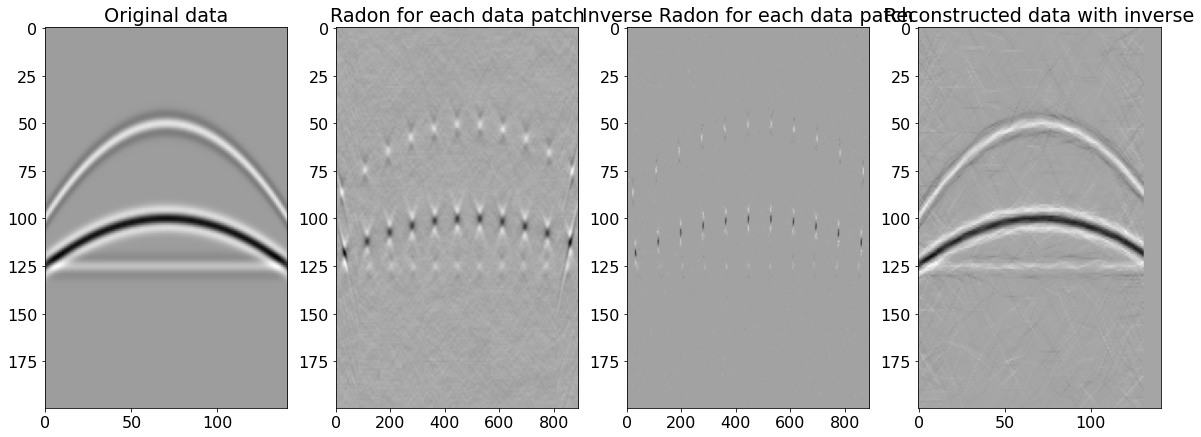

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
axs[0].axis('tight')
axs[1].imshow(radon.T, cmap='gray')
axs[1].set_title('Radon for each data patch')
axs[1].axis('tight')
axs[2].imshow(radoninv.T, cmap='gray')
axs[2].set_title('Inverse Radon for each data patch')
axs[2].axis('tight')
axs[3].imshow(reconstructed_datainv.T, cmap='gray')
axs[3].set_title('Reconstructed data with inverse')
axs[3].axis('tight');

Let's now consider the case of seismic interference. We will model some data and add an interferying arrival from another survey. While each shot will be fired at the same time (t=0) for our survey we will have some random delays on the interferring signal. We will see how we can leverage this property to transform this problem into a *denosing* problem.


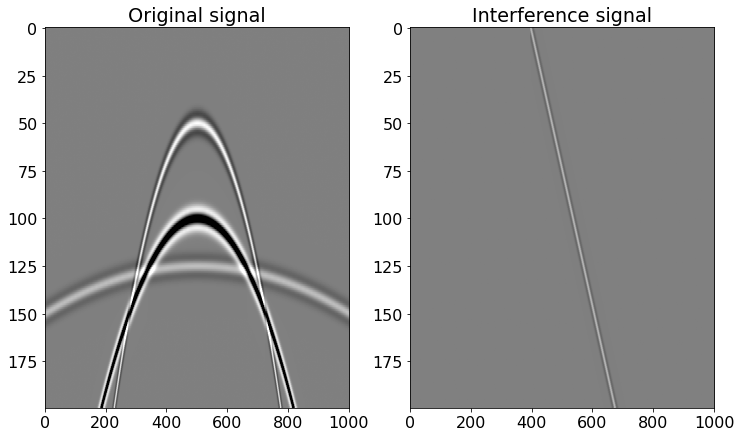

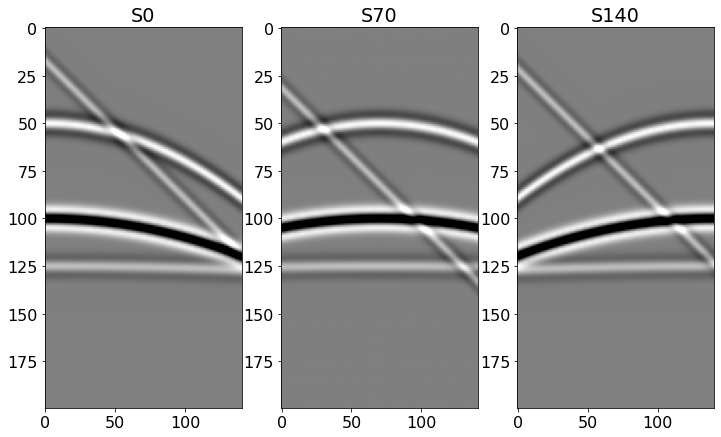

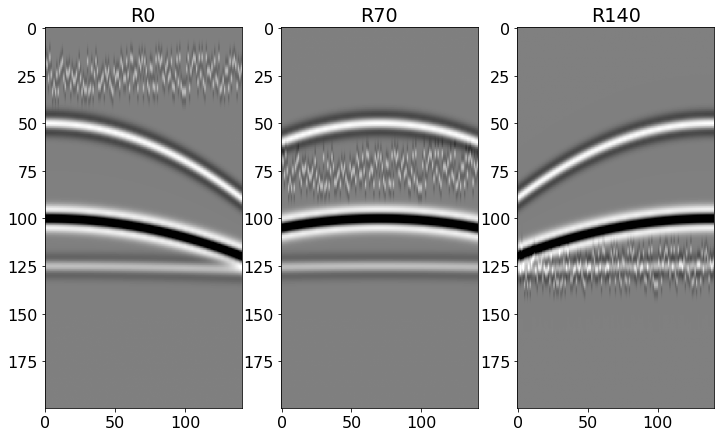

In [6]:
###### Input parameters
par = {'ox':-1000, 'dx':2, 'nx':1001,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v       = 600
t0_m    = [0.2, 0.4, 0.5]
px_m    = [0, 0, 0]
pxx_m   = [2e-6, 1e-6, 1e-7]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate superdata
_, superdata =  parabolic2d(x,t, t0_m, px_m, pxx_m, amp_m, wav)

# Generate interference
_, interference =  linear2d(x, t, v, 0.3, 60, 0.5, wav)

fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].imshow(superdata.T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('Original signal')
axs[0].axis('tight');
axs[1].imshow(interference.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Interference signal')
axs[1].axis('tight');

# Generate data
nx = 141
data = np.zeros((nx, nx, par['nt']))
interference = interference[par['nx']//2-nx//2:par['nx']//2+nx//2+1]
for i in range(nx):
    interference_shift = int(np.random.uniform(-10, 10))
    if interference_shift > 0 :
        interferencei = np.concatenate([np.zeros((nx, interference_shift)),
                                        interference[:,:-interference_shift]], axis=-1)
    else:
        interferencei = np.concatenate([interference[...,-interference_shift:],
                                        np.zeros((nx, -interference_shift))], axis=-1)
    
    data[i] = superdata[par['nx']//2-i:par['nx']//2-i+nx] + interferencei 

fig, axs = plt.subplots(1, 3, figsize=(12, 7))
axs[0].imshow(data[0].T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('S0')
axs[0].axis('tight'); 
axs[1].imshow(data[nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('S%d' %(nx//2))
axs[1].axis('tight'); 
axs[2].imshow(data[-1].T, cmap='gray', vmin=-1, vmax=1)
axs[2].set_title('S%d' %(nx-1))
axs[2].axis('tight'); 

fig, axs = plt.subplots(1, 3, figsize=(12, 7))
axs[0].imshow(data[:, 0].T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('R0')
axs[0].axis('tight'); 
axs[1].imshow(data[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('R%d' %(nx//2))
axs[1].axis('tight'); 
axs[2].imshow(data[:, -1].T, cmap='gray', vmin=-1, vmax=1)
axs[2].set_title('R%d' %(nx-1))
axs[2].axis('tight'); 

Working on rec0
Working on rec1
Working on rec2
Working on rec3
Working on rec4
Working on rec5
Working on rec6
Working on rec7
Working on rec8
Working on rec9
Working on rec10
Working on rec11
Working on rec12
Working on rec13
Working on rec14
Working on rec15
Working on rec16
Working on rec17
Working on rec18
Working on rec19
Working on rec20
Working on rec21
Working on rec22
Working on rec23
Working on rec24
Working on rec25
Working on rec26
Working on rec27
Working on rec28
Working on rec29
Working on rec30
Working on rec31
Working on rec32
Working on rec33
Working on rec34
Working on rec35
Working on rec36
Working on rec37
Working on rec38
Working on rec39
Working on rec40
Working on rec41
Working on rec42
Working on rec43
Working on rec44
Working on rec45
Working on rec46
Working on rec47
Working on rec48
Working on rec49
Working on rec50
Working on rec51
Working on rec52
Working on rec53
Working on rec54
Working on rec55
Working on rec56
Working on rec57
Working on rec58
Working

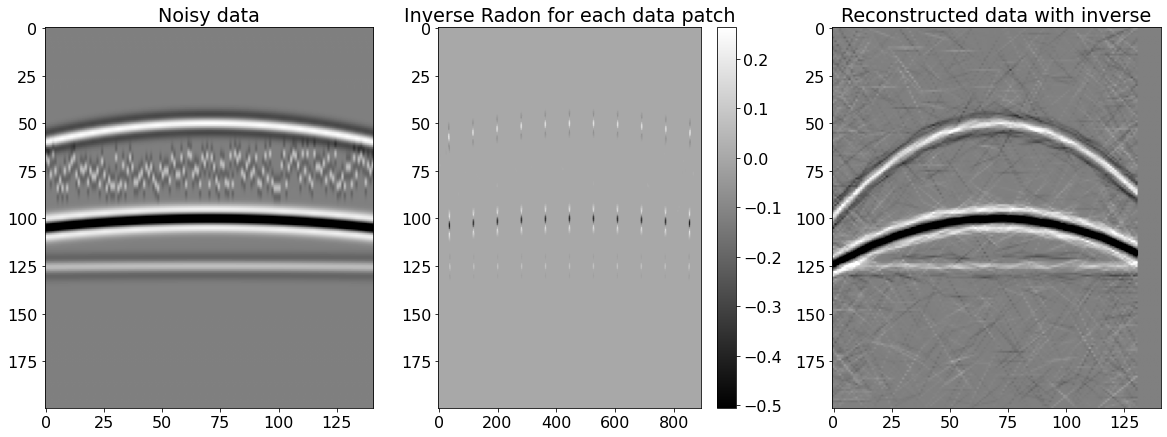

In [7]:
# sliding window radon with overlap
nwin=21
nwins=11
nover=10
npx=81
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = data[:, nx//2].shape
dims = (nwins*npx, dimsd[1])

Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), 
             px, centeredh=True, kind='linear', engine='numba')
Slid1 = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')

radoninv = fista(Slid1, data[:, nx//2].flatten(), niter=100, eps=3e0, show=0)[0]
denoiseddata = (Slid1 * radoninv).reshape(dimsd)
radoninv = radoninv.reshape(dims)

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
im = axs[0].imshow(data[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('Noisy data')
axs[0].axis('tight')
im = axs[1].imshow(radoninv.T, cmap='gray')
axs[1].set_title('Inverse Radon for each data patch')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im = axs[2].imshow(reconstructed_datainv.T, cmap='gray', vmin=-1, vmax=1)
axs[2].set_title('Reconstructed data with inverse')
axs[2].axis('tight')

# work on all recs
denoiseddata = np.zeros_like(data)
for i in range(nx):
    print('Working on rec%d' % i)
    radoninv = fista(Slid1, data[:, i].flatten(), niter=100, eps=3e0, show=0)[0]
    denoiseddata[:, i] = (Slid1 * radoninv.flatten()).reshape(dimsd)

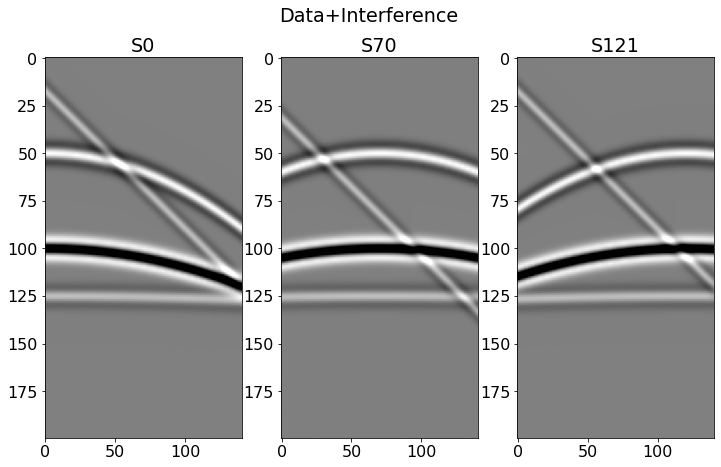

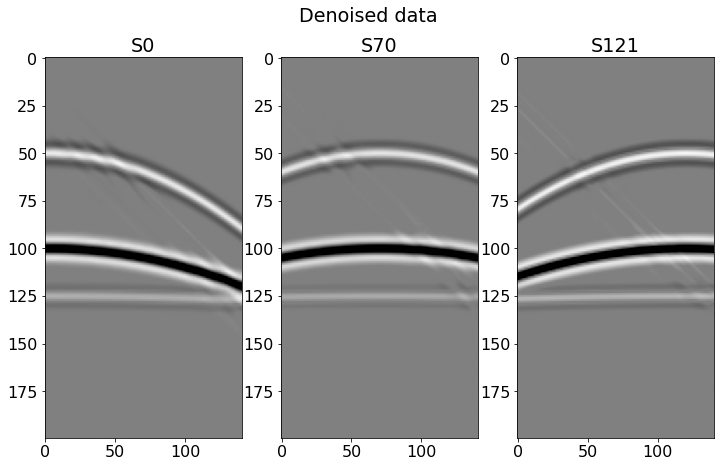

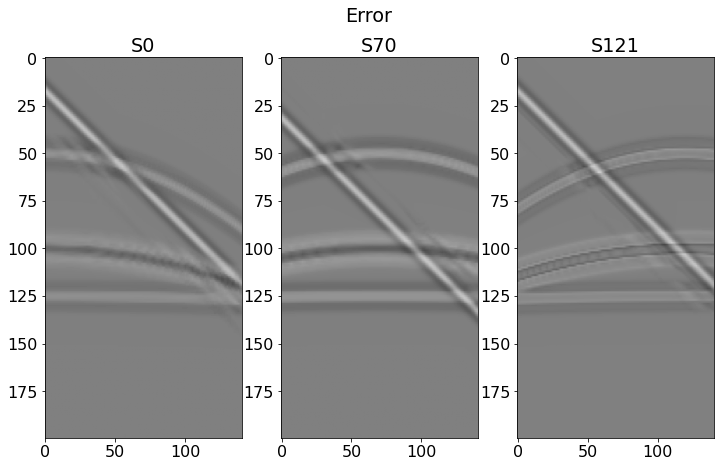

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 7))
fig.suptitle('Data+Interference')
axs[0].imshow(data[0].T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('S0')
axs[0].axis('tight'); 
axs[1].imshow(data[nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('S%d' %(nx//2))
axs[1].axis('tight'); 
axs[2].imshow(data[-20].T, cmap='gray', vmin=-1, vmax=1)
axs[2].set_title('S%d' %(nx-20))
axs[2].axis('tight'); 

fig, axs = plt.subplots(1, 3, figsize=(12, 7))
fig.suptitle('Denoised data')
axs[0].imshow(denoiseddata[0].T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('S0')
axs[0].axis('tight'); 
axs[1].imshow(denoiseddata[nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('S%d' %(nx//2))
axs[1].axis('tight'); 
axs[2].imshow(denoiseddata[-20].T, cmap='gray', vmin=-1, vmax=1)
axs[2].set_title('S%d' %(nx-20))
axs[2].axis('tight'); 

fig, axs = plt.subplots(1, 3, figsize=(12, 7))
fig.suptitle('Error')
axs[0].imshow(data[0].T - denoiseddata[0].T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('S0')
axs[0].axis('tight'); 
axs[1].imshow(data[nx//2].T - denoiseddata[nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('S%d' %(nx//2))
axs[1].axis('tight'); 
axs[2].imshow(data[-20].T - denoiseddata[-20].T, cmap='gray', vmin=-1, vmax=1)
axs[2].set_title('S%d' %(nx-20))
axs[2].axis('tight'); 